In [1]:
from copy import copy
import numpy as np
from pprint import pprint

from noworkflow.now.tagging.var_tagging import backward_deps, global_backward_deps, store_operations, resume_trials, trial_diff, trial_intersection_diff, var_tag_plot, var_tag_values

### Test case

Here starts a small test case. The workflow goes through cells defining *module*, *rmse* and a *stress_function* aiming to add some random behaviour in our test. The *var_final* is our target variable, being dependent of its previous cells.


In [2]:
def module(num): 
    if num >= 0:
        return int(num)
    else:
        return int(-1*num)

def mae(x, y):
    return np.mean(np.abs((x - y)))

def squared_diff(p, q):
    diff = p - q
    diff = diff*diff
    
    return diff

def rmse(x, y):
    
    sqr_diff = squared_diff(x, y)
    mean = np.mean(sqr_diff)
    squared_root = np.sqrt(mean)
    
    return squared_root

def stress_func(m, n):
    x = np.random.rand()
    y = np.random.rand()
    
    temp1 = rmse(m, n)
    temp2 = np.random.rand()*temp1
    
    final = np.max([int(x+y), int(temp2), mae(temp1, temp2)])
    
    return final

In [3]:
var_a = np.random.rand()

In [4]:
var_b = np.random.rand()

In [5]:
k = np.random.rand()
m = np.random.rand()

In [6]:
rme_err = mae(var_a, var_b)

In [7]:
var_c = stress_func(k, m)

In [8]:
var_d = var_c * np.random.rand()

In [9]:
var_e = mae(var_c, var_b)

In [10]:
target_var = now_tag_variable('target_var', rmse(var_c, var_e))

Evaluation(id=180, checkpoint=3.5914842019992648, code_component_id=355, activation_id=173, repr=np.float64(0.03652000733145089))


### backward_deps example
Here we recollect the backward dependencies liked with var_final tagged variable. Two options are available, with glanulatiry on and off.

In [11]:
dict_ops = backward_deps('target_var', False)
dict_ops

{9: ('k', '0.38856947240481854'),
 8: ('m', '0.642130828562119'),
 7: ('stress_func(k, m)', 'np.float64(1.0)'),
 6: ('var_c', 'np.float64(1.0)'),
 5: ('var_b', '0.03652000733145089'),
 4: ('mae(var_c, var_b)', 'complex data type'),
 3: ('var_e', 'complex data type'),
 2: ('rmse(var_c, var_e)', 'complex data type'),
 1: ("now_tag_variable('target_var', rmse(var_c, var_e))",
  'complex data type'),
 0: ('target_var', 'complex data type')}

When the flag is set True, the content of functions steps are displayed.

In [12]:
backward_deps('target_var', glanularity_level=True)

{40: ('diff', 'complex data type'),
 39: ('squared_diff(x, y)', 'complex data type'),
 38: ('sqr_diff', 'complex data type'),
 37: ('mean', 'complex data type'),
 36: ('squared_root', 'complex data type'),
 35: ('x', '0.17429571527447463'),
 34: ('y', '0.8673696024490889'),
 33: ('int(x+y)', '1'),
 32: ('int(temp2)', '0'),
 31: ('diff', '-0.25356135615730047'),
 30: ('diff', '0.06429336133632937'),
 29: ('squared_diff(x, y)', '0.06429336133632937'),
 28: ('sqr_diff', '0.06429336133632937'),
 27: ('mean', 'complex data type'),
 26: ('squared_root', 'complex data type'),
 25: ('rmse(m, n)', 'complex data type'),
 24: ('temp1', 'complex data type'),
 23: ('temp2', 'complex data type'),
 22: ('mae(temp1, temp2)', 'complex data type'),
 21: ('[int(x+y), int(temp2), mae(temp1, temp2)]', 'complex data type'),
 20: ('final', 'np.float64(1.0)'),
 19: ('k', '0.38856947240481854'),
 18: ('m', '0.642130828562119'),
 17: ('stress_func(k, m)', 'np.float64(1.0)'),
 16: ('var_c', 'np.float64(1.0)'),
 

### global_backward_deps example
Here we recollect all the backward dependencies liked with var_final tagged variable. If user redefines a tagged variable in more than one cell, this options will return all operations over this tagged variable across the trial. 
Same two options available, with glanulatiry on and off.

In [13]:
global_backward_deps('target_var', False)

{50: ('k', '0.38856947240481854'),
 49: ('m', '0.642130828562119'),
 48: ('stress_func(k, m)', 'np.float64(1.0)'),
 47: ('var_c', 'np.float64(1.0)'),
 46: ('var_b', '0.03652000733145089'),
 45: ('mae(var_c, var_b)', 'complex data type'),
 44: ('var_e', 'complex data type'),
 43: ('rmse(var_c, var_e)', 'complex data type'),
 42: ("now_tag_variable('target_var', rmse(var_c, var_e))",
  'complex data type'),
 41: ('target_var', 'complex data type'),
 40: ('diff', 'complex data type'),
 39: ('squared_diff(x, y)', 'complex data type'),
 38: ('sqr_diff', 'complex data type'),
 37: ('mean', 'complex data type'),
 36: ('squared_root', 'complex data type'),
 35: ('x', '0.17429571527447463'),
 34: ('y', '0.8673696024490889'),
 33: ('int(x+y)', '1'),
 32: ('int(temp2)', '0'),
 31: ('diff', '-0.25356135615730047'),
 30: ('diff', '0.06429336133632937'),
 29: ('squared_diff(x, y)', '0.06429336133632937'),
 28: ('sqr_diff', '0.06429336133632937'),
 27: ('mean', 'complex data type'),
 26: ('squared_ro

### trial storage example
Here we save the current trial in order to make further compariosions with other experiments. The dictionaries aren't stored in the .noworkflow/db.sqlite, but in a shelve object named *ops.db* in the current notebook local folder. **Remove it means exeperimental data being lost.**

In [14]:
store_operations(__noworkflow__.trial_id, dict_ops)

Dictionary stored in shelve.


### resume_trials

In order to support the management of experiments, the user can see the trial ids of all experiments stored in the ops.db available to comparision/analysis.

In [15]:
list_id = resume_trials()
list_id

['7765cceb-4227-459a-a6c5-4b320a4624aa',
 '2a1862df-ce34-4ef1-91fe-c43c7171112c']

### trial_intesection_diff

Two types of comparision are available now. This one refers to values returned from operations. Each variable or function call available in both experiments (intersection) have its values exhibited. 

There is a limitation in showing for complex values. Matrices and tensors cannot be properly displayed, so only an indication that is a complex type is indicated.

Here we visually plot a diff table between two trials

In [16]:
trial_intersection_diff(list_id[-2], list_id[-1])

,key,624aa,1112c
0,var_b,0.5295472290184907,0.03652000733145089
1,"rmse(var_c, var_e)",complex data type,complex data type
2,"stress_func(k, m)",complex data type,np.float64(1.0)
3,k,0.1426630853364772,0.38856947240481854
4,m,0.8152652823387299,0.642130828562119
5,"mae(var_c, var_b)",complex data type,complex data type
6,"now_tag_variable('target_var', rmse(var_c, var...",complex data type,complex data type
7,target_var,complex data type,complex data type
8,var_e,complex data type,complex data type
9,var_c,complex data type,np.float64(1.0)


### trial_diff

Here is the second way into displaying differences. The values of variables and function calls are exhibited in a diff file format, emphasizing the order of the operations carried out. The goal here is to show that between two experiments, the order of operations were different.

In [17]:
trial_diff(list_id[0], list_id[1])

### var_tag_plot

Chart the evolution of a given variable across multiple trials in the database. In this case, all experiments stored in ops.db and tagged as *target_var* has its values plotted

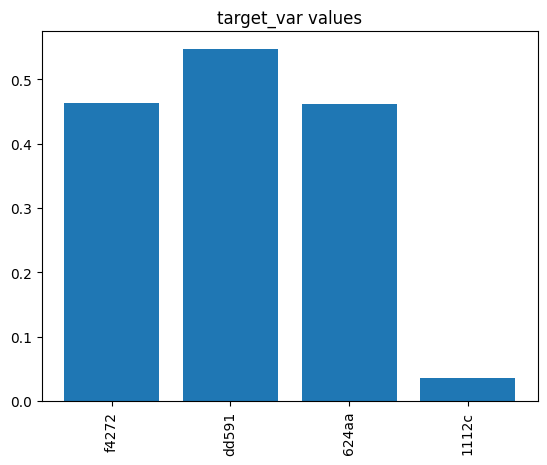

In [18]:
var_tag_plot('target_var')

### var_tag_values

In the event that the user wants to manipulate the results of all rounds, the pandas dataframe is available.

In [19]:
var_tag_values('target_var')

,trial_id,short_trial_id,tag,value
0,01643138-477b-4096-9914-5519b10f4272,f4272,target_var,0.46252700862717744
1,40033742-3f94-48ca-b7c8-ce8586cdd591,dd591,target_var,0.5469602741031943
2,7765cceb-4227-459a-a6c5-4b320a4624aa,624aa,target_var,0.46203148441277053
3,2a1862df-ce34-4ef1-91fe-c43c7171112c,1112c,target_var,0.03652000733145089
